# Auxiliary Samplers

Along with sampling the spatial and luminosity distributions, auxiliary properties and be sampled that both depend on and/or influence the luminosity. 


In [1]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1, grid=False)
green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"

import warnings
warnings.simplefilter('ignore')


import popsynth

## Creating an auxiliary sampler
Let's create two auxiliary samplers that sample values from normal distributions with some dependency on each other.

First, we specify the main population. This time, we will chose a SFR-like redshift distribution and a Schecter luminosity function


In [2]:
pop_gen = popsynth.populations.SchechterSFRPopulation(r0=10, 
                                                      rise=1.,
                                                      decay=1.,
                                                      peak=1.,
                                                      Lmin=1E50,
                                                      alpha=2.)

Suppose we have a property "demo" that we want to sample as well. For this property, we do not observe it directly. We will get to that. 


We create an AuxiliarySampler child class, and define the *true_sampler* for the latent values

In [3]:
class DemoSampler(popsynth.AuxiliarySampler):
    
    def __init__(self, mu=2, tau=1., sigma=1):
        
        self._mu = mu
        self._tau=tau
        
        # store the simulated values
        truth = dict(mu=mu, tau=tau)
        
        # pass up to the super class
        super(DemoSampler, self).__init__('demo', sigma, observed=False, truth=truth)
        
    def true_sampler(self, size):
        
        # sample the latent values for this property
        
        self._true_values =  np.random.normal(self._mu, self._tau, size=size)
        

Now we instantiate it and then assign it our pop_gen object. Then we draw out survey

registering auxilary sampler: demo
The volume integral is 669.519846



Expecting 644 total objects
Sampling: demo
Applying hard boundary
Deteced 216 objects or to a distance of 2.94


<IPython.core.display.Javascript object>


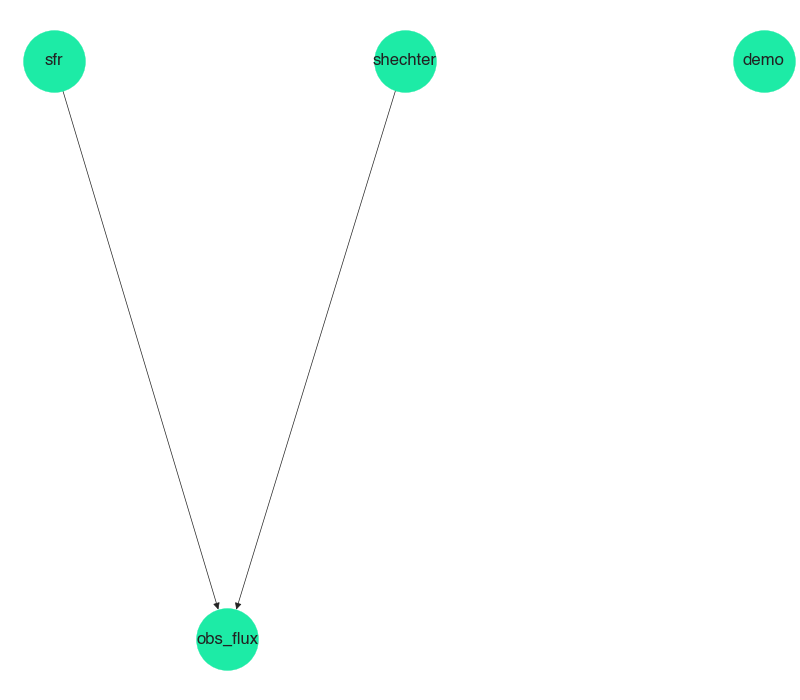

In [4]:
demo1 = DemoSampler()

pop_gen.add_observed_quantity(demo1)

population = pop_gen.draw_survey(boundary=1E-8, hard_cut=True, flux_sigma= 0.1,verbose=True)

options = {
'node_color':green,
'node_size': 2000,
'width': .5}


pos=nx.drawing.nx_agraph.graphviz_layout(
        population.graph, prog='dot'
    )
    
nx.draw(population.graph, with_labels=True,pos=pos, **options)


<IPython.core.display.Javascript object>


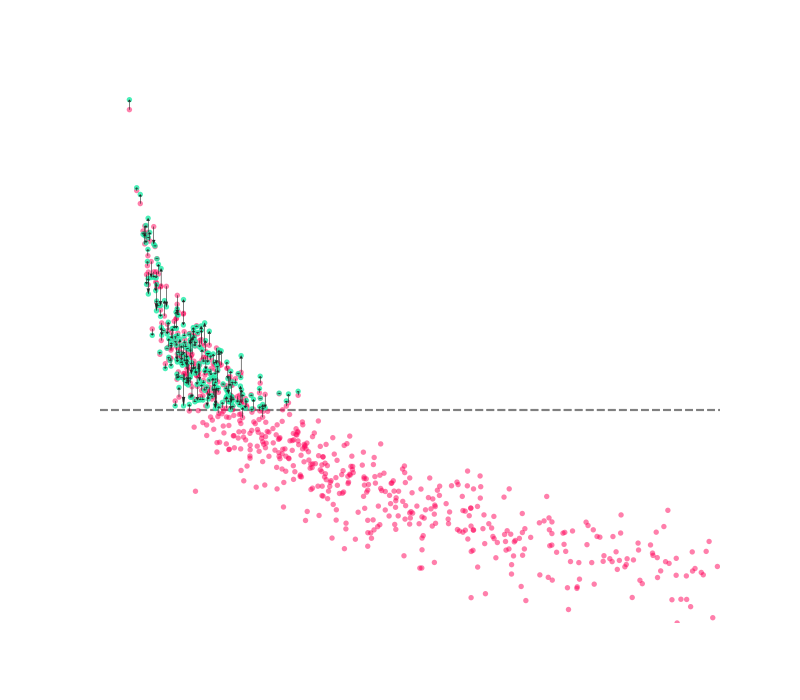

In [5]:
population.display_fluxes(obs_color=green, true_color=red,s=15);

We can see that the population has stored out demo auxiliary property

In [6]:
population.demo

array([ 0.47559219,  1.90962278,  3.84629023,  3.04164133,  2.26279198,
        1.6399173 ,  3.39894773,  1.93779114,  1.24178317,  1.91425349,
        2.20934588,  1.85052738,  3.20653856,  2.12060415,  2.93726614,
        0.66784731,  0.99870847,  2.06600903,  1.75928122,  2.40030565,
        1.72924795,  2.7831162 ,  0.84832244,  3.27178484, -0.1527074 ,
        2.26123994,  2.81993786,  1.68722358,  2.2810808 ,  1.5711745 ,
        1.80848288,  1.30142731,  2.28619239,  2.57637719,  2.21085321,
       -0.02679571,  0.62880017,  2.93996847,  2.49043676,  2.56974424,
        1.63859623,  3.80859012,  2.32837603,  1.50752315,  1.30959757,
        2.29713751,  3.03771865,  2.02660177,  2.44823619,  3.02491785,
        1.53044466,  1.67662846,  1.91335727,  1.13757194,  3.15598616,
        1.41635599,  0.58353947,  2.79919574, -0.06385626,  1.54232697,
        2.31579539,  1.98604068,  1.62393126,  1.28464379,  3.80275951,
        0.46047398,  3.14438203,  2.13759794,  1.28973388,  1.52

In [7]:
population.demo_selected

array([ 3.84629023,  1.91425349,  1.85052738,  0.99870847,  1.72924795,
        2.7831162 ,  0.84832244,  2.81993786,  2.2810808 ,  2.21085321,
        1.50752315,  1.53044466,  1.67662846,  1.91335727,  1.41635599,
       -0.06385626,  1.54232697,  3.80275951,  0.46047398,  4.24315991,
        1.33226367,  2.91539628,  2.75055314,  1.02110682,  3.1018286 ,
        0.99718787,  1.68500471,  2.13837709,  3.53785286,  3.1950939 ,
        2.07491606,  4.35726554,  1.92359634,  2.32266569,  1.76637386,
        1.66445109,  0.96345501,  2.08355101,  1.44374158,  4.04749328,
        1.39414328,  0.90316765,  0.89883366,  0.83774513,  2.66951524,
        2.48339779,  2.86030411,  1.21518713,  0.68448449,  2.68752447,
        2.41442095,  3.05881472,  1.88210207,  0.14657921,  1.29815056,
        2.27658038,  2.63528512,  1.47232385,  1.85285814,  2.63058267,
        4.02491453,  0.31253287,  1.15992349,  4.23258264,  0.24131366,
        3.97785169,  3.63411831,  0.23545495,  2.10565472,  2.60

## Observed auxiliary properties and dependent parameters

Suppose now we want to simulate a property that is observed by an instrument but depends on latent parameters.

We will create a second demo sampler and tell it what the observational error is as well as how to read from a secondary sampler:

In [8]:
class DemoSampler2(popsynth.AuxiliarySampler):
    def __init__(self, mu=2, tau=1., sigma=1):
        self._mu = mu
        self._tau=tau
        
        # store the simulated values
        truth = dict(mu=mu, tau=tau)
        
        # this time set observed=True
        super(DemoSampler2, self).__init__('demo2', sigma, observed=True, truth=truth, uses_distance=True)
        
    def true_sampler(self, size):
        
        # we access the secondary sampler dictionary. In this 
        # case "demo". This itself is a sampler with 
        # <>.true_values as a parameter
        secondary = self._secondary_samplers['demo']
        
        # now we sample the demo2 latent values and add on the dependence of "demo"
        
        tmp =  (np.random.normal(self._mu , self._tau, size=size))
        
        # for fun, we can substract the log of the distance as all
        # auxiliary samples know about their distances
        
        self._true_values = tmp + secondary.true_values - np.log10(1+self._distance)
        
    def observation_sampler(self, size):
        
        # here we define the "observed" values, i.e., the latened values 
        # with observational error
        
        self._obs_values =  self._true_values + np.random.normal(0, self._sigma, size=size)


We recreate our base sampler:

In [9]:
pop_gen = popsynth.populations.SchechterSFRPopulation(r0=10, 
                                                      rise=1.,
                                                      decay=1.,
                                                      peak=1.,
                                                      Lmin=1E50,
                                                      alpha=2.)


Now, make a new *demo1*, but this time we do not have to attach it to the base sampler. Instead, we will assign it as a secondary sampler to *demo2* and **popsynth** is smart enough to search for it when it draws a survey. 

In [10]:
demo1 = DemoSampler()


demo2 = DemoSampler2()

demo2.set_secondary_sampler(demo1)

# attach to the base sampler
pop_gen.add_observed_quantity(demo2)




registering auxilary sampler: demo2


In [11]:
pos=nx.drawing.nx_agraph.graphviz_layout(
        pop_gen.graph, prog='dot'
    )
    
nx.draw(pop_gen.graph, with_labels=True,pos=pos, **options)



In [12]:
population = pop_gen.draw_survey(boundary=1E-8, hard_cut=True, flux_sigma= 0.1,verbose=True)

The volume integral is 669.519846



Expecting 644 total objects
Sampling: demo2
demo2 is sampling its secondary quantities
Sampling: demo
Applying hard boundary
Deteced 219 objects or to a distance of 2.94


<IPython.core.display.Javascript object>


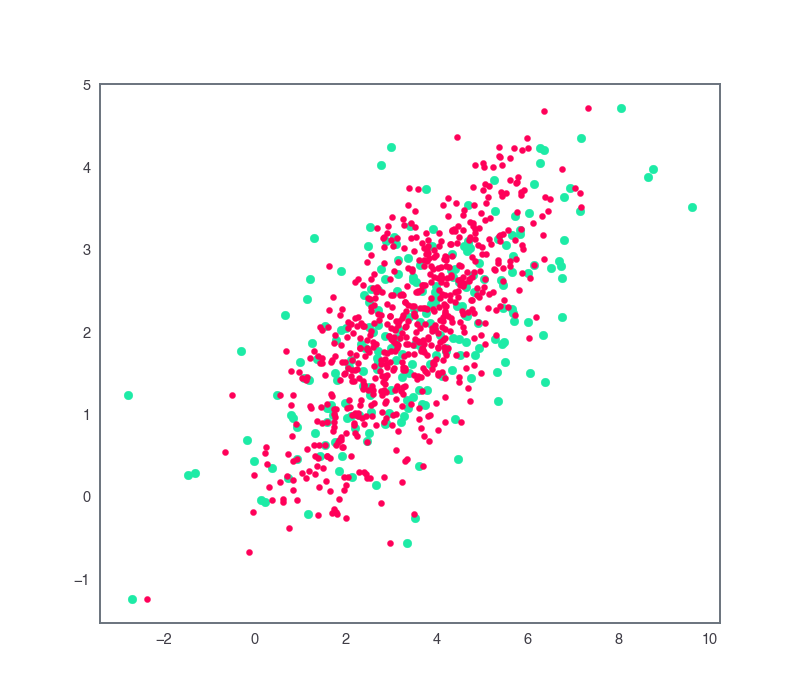

In [13]:
fig, ax = plt.subplots()

ax.scatter(population.demo2_selected, population.demo_selected ,c=green,s=40)

ax.scatter(population.demo2, population.demo ,c=red,s=20)

## Derived Luminosity sampler

Sometimes, the luminosity does not come directly from a distribution. Rather, it is computed from other quantities. In these cases, we want to use the **DerivedLumAuxSampler** class.

This allows you to sample auxiliary parameters and compute a luminosity from those. 

In [14]:

class DemoSampler3(popsynth.DerivedLumAuxSampler):
    def __init__(self, mu=2, tau=1., sigma=1):
        self._mu = mu
        self._tau=tau
        
        # store the simulated values
        truth = dict(mu=mu, tau=tau)
        
        # this time set observed=True
        super(DemoSampler3, self).__init__('demo3', sigma=1, truth=truth, uses_distance=False)
        
    def true_sampler(self, size):
    
        # draw a random number
        tmp =  np.random.normal(self._mu , self._tau, size=size)
     
        self._true_values = tmp 
        
    def compute_luminosity(self):
        
        # compute the luminosity
        secondary = self._secondary_samplers["demo"]

        return (10 ** (self._true_values + 54)) / secondary.true_values

In [15]:
pop_gen = popsynth.populations.SchechterSFRPopulation(r0=10, 
                                                      rise=1.,
                                                      decay=1.,
                                                      peak=1.,
                                                      Lmin=1E50,
                                                      alpha=2.)





registering derived luminosity sampler: demo3


<IPython.core.display.Javascript object>


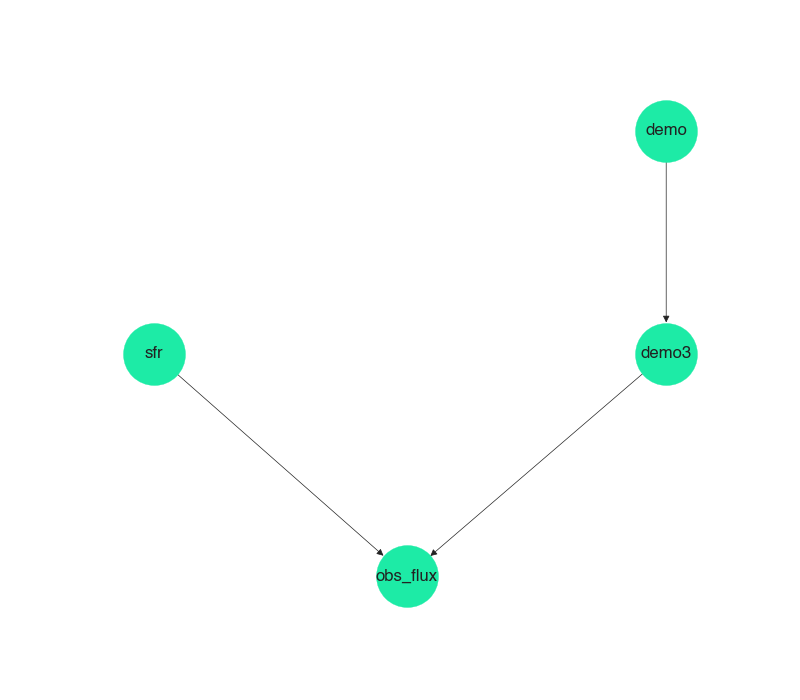

In [16]:
demo1 = DemoSampler()


demo3 = DemoSampler3()

demo3.set_secondary_sampler(demo1)

# attach to the base sampler
pop_gen.add_observed_quantity(demo3)


pos=nx.drawing.nx_agraph.graphviz_layout(
        pop_gen.graph, prog='dot'
    )
 
fig, ax = plt.subplots()
    
nx.draw(pop_gen.graph, with_labels=True,pos=pos, **options, ax=ax)

In [17]:
population = pop_gen.draw_survey(boundary=1E-5, hard_cut=True, flux_sigma= 0.1,verbose=True)

The volume integral is 669.519846



Expecting 644 total objects
Sampling: demo3
demo3 is sampling its secondary quantities
Sampling: demo
Getting luminosity from derived sampler
Applying hard boundary
Deteced 582 objects or to a distance of 9.88


<IPython.core.display.Javascript object>


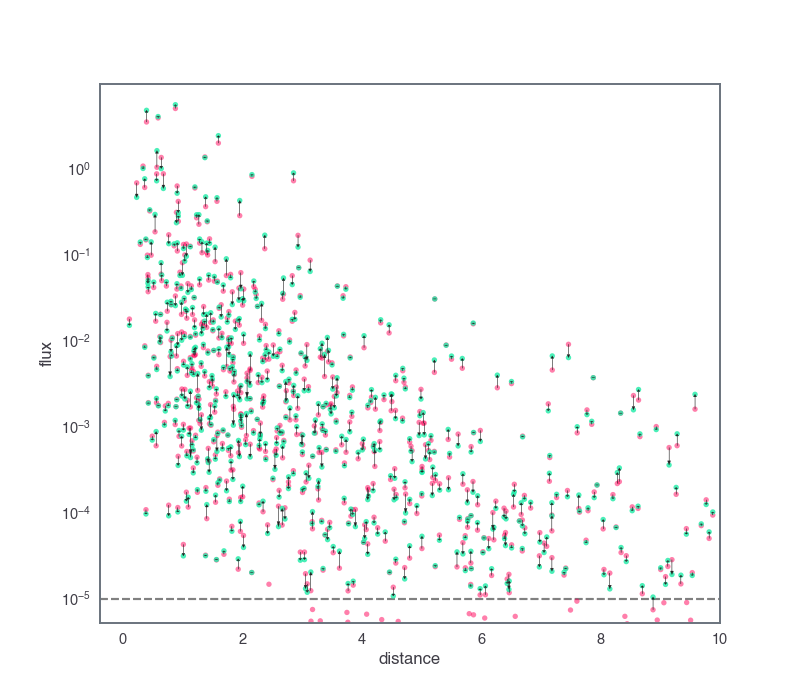

In [18]:
population.display_fluxes(obs_color=green, true_color=red,s=15);